# ECoG Classification

In [1]:
from scipy.io import loadmat
import numpy as np
import mne
import glob

data = loadmat("ECoG_Handpose.mat", struct_as_record=True)

data_ = data["y"]
data_ecog = data_[1:60, :]
nchannels, nsamples = data_ecog.shape
label = data_[61, :]
sample_time = data_[1, :]

# Create MNE Structure
# Create Info
n_channels = 59
sfreq = 1200  # in Hertz
info = mne.create_info(n_channels, sfreq=sfreq, ch_types="ecog")

raw = mne.io.RawArray(data_ecog, info)
# raw.plot()
# raw.plot_psd(spatial_colors=True)


# Create Events, Exclude Relax
events = []
for i in np.arange(1, len(label)):
    if label[i-1] != label[i] and label[i] != 0:
        events.append((i, 0, int(label[i])))

events = np.array(events)

event_id = {
'Fist': 1,
'Peace': 2,
'Open': 3,
}

# raw.plot(events=events, event_id=event_id)

Creating RawArray with float64 data, n_channels=59, n_times=507025
    Range : 0 ... 507024 =      0.000 ...   422.520 secs
Ready.


In [2]:
# ====================================================================================================================
# REREFERENCING by COMMON AVERAGE
# ====================================================================================================================
referenced_raw, _ = mne.set_eeg_reference(raw, ref_channels="average", copy=True, ch_type="ecog")
# referenced_raw.plot(events=events, event_id=event_id)
# referenced_raw.plot_psd()

Applying average reference.
Applying a custom ('ECoG',) reference.


In [3]:
# ====================================================================================================================
# NOTCH FILTER
# ====================================================================================================================
# Remove power line artifact (visible from psd visualization)
iir_params = dict(order=6, ftype='butter', output='sos')
raw_notch0 = referenced_raw.copy().notch_filter(freqs=50, method='iir', iir_params=iir_params)
raw_notch1 = raw_notch0.copy().notch_filter(freqs=100, method='iir', iir_params=iir_params)
raw_notch2 = raw_notch1.copy().notch_filter(freqs=150, method='iir', iir_params=iir_params)
raw_notch3 = raw_notch2.copy().notch_filter(freqs=200, method='iir', iir_params=iir_params)
raw_notch4 = raw_notch3.copy().notch_filter(freqs=250, method='iir', iir_params=iir_params)
raw_notch = raw_notch4.copy().notch_filter(freqs=300, method='iir', iir_params=iir_params)

# Plot PSD
# raw_notch.plot(events=events, event_id=event_id)
# raw_notch.plot_psd()

Setting up band-stop filter from 49 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 99 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 99.25, 100.75 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 1.5e+02 - 1.5e+02 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 149.12, 150.88 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 2e+02 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal

In [4]:
# ====================================================================================================================
# BAND-PASS FILTER
# ====================================================================================================================
# Inspect data
# raw.plot()
# filt_low, filt_high = 6, 14
filt_low, filt_high = 50, 300
# Apply band_pass filter
iir_params = dict(order=6, ftype='butter', output='sos')
raw_bandpass = raw_notch.copy().filter(l_freq=filt_low, h_freq=filt_high, method="iir")
# raw_bandpass.plot()
# raw_bandpass.plot_psd(spatial_colors=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 50 - 3e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 50.00, 300.00 Hz: -6.02, -6.02 dB



In [5]:
# ====================================================================================================================
# LOG TRANSFORM
# ====================================================================================================================
# TODO

In [6]:
# ====================================================================================================================
# EPOCH
# ====================================================================================================================
# Epoch starts 0.3 seconds before events and end 0.5 second after the events
t_min = 0
t_max = 2

# Create the Epoch
epochs = mne.Epochs(raw_bandpass,
                    events=events,
                    event_id=event_id,
                    tmin=t_min,
                    tmax=t_max,
                    baseline=None,
                    preload=True)

# Plot
# epochs.plot(events=events)

Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 2401 original time points ...
0 bad epochs dropped


In [7]:
# ====================================================================================================================
# CREATION DATASET
# ====================================================================================================================
# Create the X and y dataset
X = epochs.get_data()
y = epochs.events[:, -1]

np.save('X.npy',X)
np.save('y.npy',y)

In [8]:
# ====================================================================================================================
# SPECTRAL WHITENING
# ====================================================================================================================
from scipy import signal
from mne.time_frequency import fit_iir_model_raw
order = 10  # define model order

# Estimate AR models on raw data
b, a = fit_iir_model_raw(raw_bandpass, order=order)

for i in np.arange(X.shape[0]):
    for j in np.arange(X.shape[1]):
        d = X[i][j, :]  # look at one channel from now on
        d = d.ravel()  # make flat vector
        innovation = signal.convolve(d, a, 'valid')
        d_ = signal.lfilter(b, a, innovation)  # regenerate the signal
        d_ = np.r_[d_[0] * np.ones(order), d_]  # dummy samples to keep signal length
        X[i][j, :] = d_

# Classifier Riemann Approach

In [9]:
# ====================================================================================================================
## Classification COV+EN
# ====================================================================================================================
from pyriemann.classification import MDM
from pyriemann.estimation import Covariances
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from pyriemann.tangentspace import TangentSpace

cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Classifier to test
clf = Pipeline(steps=[
    ("Covariances", Covariances("lwf")),
    ("Tangent_Space", TangentSpace(metric="riemann")),
    ("LogistReg", LogisticRegression(penalty="elasticnet", l1_ratio=0.15, intercept_scaling=1000.0, solver="saga"))
])

# Use scikit-learn Pipeline with cross_val_score function
scores = cross_val_score(clf, X, y, cv=cv, n_jobs=1, scoring="accuracy")

print("Classification accuracy: %.3f +/- %.3f" %(np.mean(scores), np.std(scores)))

Classification accuracy: 0.967 +/- 0.051


In [10]:
# ====================================================================================================================
# GridSearch
# ====================================================================================================================
from sklearn.model_selection import GridSearchCV
param_grid = {
    'LogistReg__l1_ratio': [0.1, 0.15]
}

search = GridSearchCV(clf, param_grid, refit=True, cv=cv, verbose=3)

search.fit(X, y)
# print best parameter after tuning
print(search.best_params_)
clf.set_params(**search.best_params_)

# Use scikit-learn Pipeline with cross_val_score function
scores = cross_val_score(clf, X, y, cv=cv, n_jobs=1, scoring="accuracy")

print("Classification accuracy: %.3f +/- %.3f" %(np.mean(scores), np.std(scores)))

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10] END ..........LogistReg__l1_ratio=0.1;, score=0.889 total time=   1.2s
[CV 2/10] END ..........LogistReg__l1_ratio=0.1;, score=1.000 total time=   1.3s
[CV 3/10] END ..........LogistReg__l1_ratio=0.1;, score=0.889 total time=   1.2s
[CV 4/10] END ..........LogistReg__l1_ratio=0.1;, score=1.000 total time=   1.2s
[CV 5/10] END ..........LogistReg__l1_ratio=0.1;, score=0.889 total time=   1.2s
[CV 6/10] END ..........LogistReg__l1_ratio=0.1;, score=0.889 total time=   1.2s
[CV 7/10] END ..........LogistReg__l1_ratio=0.1;, score=0.889 total time=   1.2s
[CV 8/10] END ..........LogistReg__l1_ratio=0.1;, score=1.000 total time=   1.2s
[CV 9/10] END ..........LogistReg__l1_ratio=0.1;, score=1.000 total time=   1.2s
[CV 10/10] END .........LogistReg__l1_ratio=0.1;, score=0.889 total time=   1.2s
[CV 1/10] END .........LogistReg__l1_ratio=0.15;, score=0.889 total time=   1.2s
[CV 2/10] END .........LogistReg__l1_ratio=0.15;

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        30
           3       1.00      1.00      1.00        30

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90

Accuracy score (Train): 1.000000e+00
              precision    recall  f1-score   support

           1       0.97      0.97      0.97        30
           2       0.94      0.97      0.95        30
           3       1.00      0.97      0.98        30

    accuracy                           0.97        90
   macro avg       0.97      0.97      0.97        90
weighted avg       0.97      0.97      0.97        90

Accuracy score (Test): 9.666667e-01
Classification accuracy: 0.967 +/- 0.051
Computational time: 1.422927e+01 secs
Memory Usage: 2.795574e+00 MByte


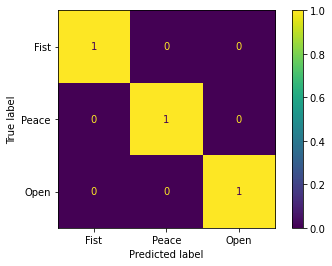

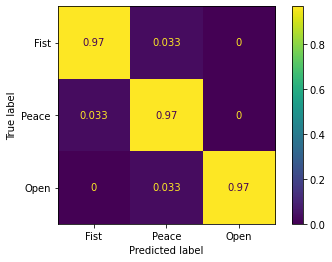

In [11]:
# ====================================================================================================================
# Print Results
# ====================================================================================================================
import time
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, jaccard_score, hamming_loss
# Define Variable to save the Results
pred_train = np.zeros(len(y))
pred_test = np.zeros(len(y))

# Compute Starting Time
time_start = time.perf_counter()

for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the Model on the Training Dataset
    clf.fit(X_train, y_train)

    # Compute Y_pred using the MDM classifier on the Test Dataset
    pred_train[train_index] = clf.predict(X_train)

    # Compute Y_pred using the MDM classifier on the Test Dataset
    pred_test[test_index] = clf.predict(X_test)

# Compute Final Time of the Algorithm
time_elapsed = (time.perf_counter() - time_start)

# ===================================================================================================================
# Train Performances
# ===================================================================================================================
print(classification_report(y, pred_train))
print("Accuracy score (Train): {:e}".format(accuracy_score(y, pred_train)))

# Train Confusion Matrix
cm = confusion_matrix(y, pred_train, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=event_id.keys()).plot()


# ===================================================================================================================
# Test Performances
# ===================================================================================================================
print(classification_report(y, pred_test))
print("Accuracy score (Test): {:e}".format(accuracy_score(y, pred_test)))
print("Classification accuracy: %.3f +/- %.3f" %(np.mean(scores), np.std(scores)))

# Train Confusion Matrix
cm = confusion_matrix(y, pred_test, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=event_id.keys()).plot()

# ===================================================================================================================
# Computational Performances
# ===================================================================================================================
import resource
print("Computational time: {:e} secs".format(time_elapsed))
memMb = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024.0/1024.0
print("Memory Usage: {:e} MByte".format(memMb))

## Classification Naive Bayes - NO NEED OF PREPROCESSING

In [12]:
# ====================================================================================================================
# EPOCH
# ====================================================================================================================
# Epoch starts 0.3 seconds before events and end 0.5 second after the events
t_min = 0
t_max = 2

# Create the Epoch
epochs = mne.Epochs(raw,
                    events=events,
                    event_id=event_id,
                    tmin=t_min,
                    tmax=t_max,
                    baseline=None,
                    preload=True)

# Plot
# epochs.plot(events=events)

# ====================================================================================================================
# CREATION DATASET
# ====================================================================================================================
# Create the X and y dataset
X = epochs.get_data()
y = epochs.events[:, -1]


from pyriemann.classification import MDM
from pyriemann.estimation import Covariances
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import FgMDM
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Classifier to test
clf = Pipeline(steps=[
    ("Covariances", Covariances("lwf")),
    ("Tangent_Space", TangentSpace(metric="riemann")),
    ("GaussianNB", GaussianNB(priors=None, var_smoothing=0.0008111308307896872))
])

# Use scikit-learn Pipeline with cross_val_score function
scores = cross_val_score(clf, X, y, cv=cv, n_jobs=1, scoring="accuracy")

print("Classification accuracy: %.3f +/- %.3f" %(np.mean(scores), np.std(scores)))

Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 2401 original time points ...
0 bad epochs dropped
Classification accuracy: 0.933 +/- 0.054


In [15]:
# ====================================================================================================================
## GridSearch
# ====================================================================================================================
from sklearn.model_selection import GridSearchCV

var_smoothing = np.logspace(0, -4, num=4)

param_grid = {
    'GaussianNB__var_smoothing': var_smoothing
}

search = GridSearchCV(clf, param_grid, refit=True, cv=cv, verbose=3)

search.fit(X, y)
# print best parameter after tuning
print(search.best_params_)
clf.set_params(**search.best_params_)

# Use scikit-learn Pipeline with cross_val_score function
scores = cross_val_score(clf, X, y, cv=cv, n_jobs=1, scoring="accuracy")

print("Classification accuracy: %.3f +/- %.3f" %(np.mean(scores), np.std(scores)))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10] END ....GaussianNB__var_smoothing=1.0;, score=0.667 total time=   1.4s
[CV 2/10] END ....GaussianNB__var_smoothing=1.0;, score=0.444 total time=   1.4s
[CV 3/10] END ....GaussianNB__var_smoothing=1.0;, score=0.556 total time=   1.3s
[CV 4/10] END ....GaussianNB__var_smoothing=1.0;, score=0.778 total time=   1.3s
[CV 5/10] END ....GaussianNB__var_smoothing=1.0;, score=0.556 total time=   1.4s
[CV 6/10] END ....GaussianNB__var_smoothing=1.0;, score=0.667 total time=   1.4s
[CV 7/10] END ....GaussianNB__var_smoothing=1.0;, score=0.778 total time=   1.4s
[CV 8/10] END ....GaussianNB__var_smoothing=1.0;, score=0.667 total time=   1.4s
[CV 9/10] END ....GaussianNB__var_smoothing=1.0;, score=0.889 total time=   1.4s
[CV 10/10] END ...GaussianNB__var_smoothing=1.0;, score=0.444 total time=   1.4s
[CV 1/10] END GaussianNB__var_smoothing=0.046415888336127795;, score=0.667 total time=   1.4s
[CV 2/10] END GaussianNB__var_smoot

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        30
           3       1.00      1.00      1.00        30

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90

Accuracy score (Train): 1.000000e+00
              precision    recall  f1-score   support

           1       0.92      0.80      0.86        30
           2       0.85      0.93      0.89        30
           3       0.94      0.97      0.95        30

    accuracy                           0.90        90
   macro avg       0.90      0.90      0.90        90
weighted avg       0.90      0.90      0.90        90

Accuracy score (Test): 9.000000e-01
Classification accuracy: 0.900 +/- 0.078
Computational time: 1.622650e+01 secs
Memory Usage: 3.832611e+00 MByte


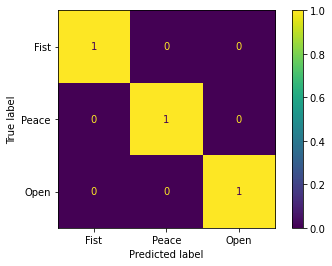

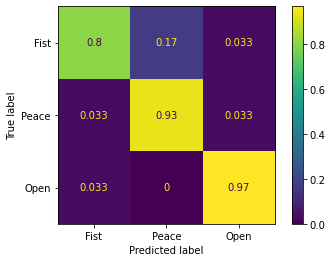

In [16]:
# ====================================================================================================================
# Print Results
# ====================================================================================================================
import time
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, jaccard_score, hamming_loss
# Define Variable to save the Results
pred_train = np.zeros(len(y))
pred_test = np.zeros(len(y))

# Compute Starting Time
time_start = time.perf_counter()

for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the Model on the Training Dataset
    clf.fit(X_train, y_train)

    # Compute Y_pred using the MDM classifier on the Test Dataset
    pred_train[train_index] = clf.predict(X_train)

    # Compute Y_pred using the MDM classifier on the Test Dataset
    pred_test[test_index] = clf.predict(X_test)

# Compute Final Time of the Algorithm
time_elapsed = (time.perf_counter() - time_start)

# ===================================================================================================================
# Train Performances
# ===================================================================================================================
print(classification_report(y, pred_train))
print("Accuracy score (Train): {:e}".format(accuracy_score(y, pred_train)))

# Train Confusion Matrix
cm = confusion_matrix(y, pred_train, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=event_id.keys()).plot()


# ===================================================================================================================
# Test Performances
# ===================================================================================================================
print(classification_report(y, pred_test))
print("Accuracy score (Test): {:e}".format(accuracy_score(y, pred_test)))
print("Classification accuracy: %.3f +/- %.3f" %(np.mean(scores), np.std(scores)))

# Train Confusion Matrix
cm = confusion_matrix(y, pred_test, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=event_id.keys()).plot()

# ===================================================================================================================
# Computational Performances
# ===================================================================================================================
import resource
print("Computational time: {:e} secs".format(time_elapsed))
memMb = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024.0/1024.0
print("Memory Usage: {:e} MByte".format(memMb))

## Sliding Windows Approach

In [17]:
def delete_some_class (X, Y, labels_to_drop):    
    for i in range(len(labels_to_drop)):
        curr_label = labels_to_drop[i];
        X.drop(Y.loc[Y['label']==curr_label].index, inplace=True)
        Y.drop(Y.loc[Y['label']==curr_label].index, inplace=True)
        
    X = X.reset_index(drop=True)
    Y = Y.reset_index(drop=True)

    return X, Y

In [18]:
# ====================================================================================================================
## SLIDING WINDOW APPROACH
# ====================================================================================================================
import pandas as pd
from sklearn.preprocessing import StandardScaler

X = pd.read_csv('X_prep_data.csv')
y = pd.read_csv('y_prep_data.csv')

scaler = StandardScaler()

X, y = delete_some_class(X.reset_index(drop=True), y.reset_index(drop=True), [0])

X = pd.DataFrame(scaler.fit_transform(X))

y = y['label'].ravel()

In [19]:
# ====================================================================================================================
## Classifier
# ====================================================================================================================
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

cv = KFold(n_splits=10, shuffle=True, random_state=0)

# Classifier to test
clf = Pipeline(steps=[
    ("SVM", SVC(C=10**2, gamma=10**-3, kernel='rbf'))
])

# Use scikit-learn Pipeline with cross_val_score function
scores = cross_val_score(clf, X, y, cv=cv, n_jobs=1, scoring="accuracy")

print("Classification accuracy: %.3f +/- %.3f" %(np.mean(scores), np.std(scores)))

Classification accuracy: 0.999 +/- 0.003


In [20]:
# ====================================================================================================================
## GridSearch
# ====================================================================================================================
from sklearn.model_selection import GridSearchCV

C_values = [10, 100]
gamma_values = [0.001, 0.1]
kernels = ['rbf']

param_grid = {
    'SVM__C': C_values,
    'SVM__gamma': gamma_values,
    'SVM__kernel': kernels
}

search = GridSearchCV(clf, param_grid, refit=True, cv=cv, verbose=3)

search.fit(X, y)
# print best parameter after tuning
print(search.best_params_)
clf.set_params(**search.best_params_)

# Use scikit-learn Pipeline with cross_val_score function
scores = cross_val_score(clf, X, y, cv=cv, n_jobs=1, scoring="accuracy")

print("Classification accuracy: %.3f +/- %.3f" %(np.mean(scores), np.std(scores)))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10] END SVM__C=10, SVM__gamma=0.001, SVM__kernel=rbf;, score=1.000 total time=   0.1s
[CV 2/10] END SVM__C=10, SVM__gamma=0.001, SVM__kernel=rbf;, score=0.989 total time=   0.1s
[CV 3/10] END SVM__C=10, SVM__gamma=0.001, SVM__kernel=rbf;, score=1.000 total time=   0.1s
[CV 4/10] END SVM__C=10, SVM__gamma=0.001, SVM__kernel=rbf;, score=0.989 total time=   0.1s
[CV 5/10] END SVM__C=10, SVM__gamma=0.001, SVM__kernel=rbf;, score=1.000 total time=   0.1s
[CV 6/10] END SVM__C=10, SVM__gamma=0.001, SVM__kernel=rbf;, score=1.000 total time=   0.1s
[CV 7/10] END SVM__C=10, SVM__gamma=0.001, SVM__kernel=rbf;, score=1.000 total time=   0.1s
[CV 8/10] END SVM__C=10, SVM__gamma=0.001, SVM__kernel=rbf;, score=1.000 total time=   0.1s
[CV 9/10] END SVM__C=10, SVM__gamma=0.001, SVM__kernel=rbf;, score=1.000 total time=   0.1s
[CV 10/10] END SVM__C=10, SVM__gamma=0.001, SVM__kernel=rbf;, score=0.978 total time=   0.1s
[CV 1/10] END SVM_

In [21]:
X_arr = np.array(X)
y_arr = np.array(y)

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       311
         2.0       1.00      1.00      1.00       315
         3.0       1.00      1.00      1.00       312

    accuracy                           1.00       938
   macro avg       1.00      1.00      1.00       938
weighted avg       1.00      1.00      1.00       938

Accuracy score (Train): 1.000000e+00
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       311
         2.0       1.00      1.00      1.00       315
         3.0       1.00      1.00      1.00       312

    accuracy                           1.00       938
   macro avg       1.00      1.00      1.00       938
weighted avg       1.00      1.00      1.00       938

Accuracy score (Test): 9.989339e-01
Classification accuracy: 0.999 +/- 0.003


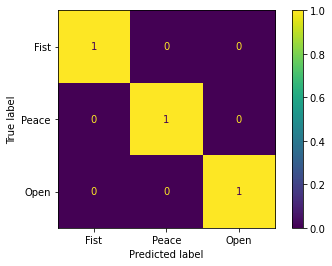

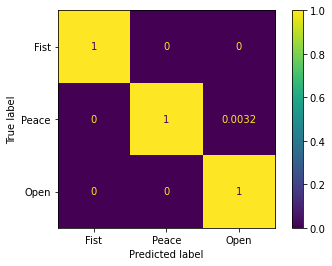

In [22]:
# ====================================================================================================================
# Print Results
# ====================================================================================================================
import time
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, jaccard_score, hamming_loss

# Define Variable to save the Results
pred_train = np.zeros(len(y_arr))
pred_test = np.zeros(len(y_arr))

# Compute Starting Time
time_start = time.perf_counter()

for train_index, test_index in cv.split(X):
    #print(train_index.dtype)
    #print(test_index.dtype)
    train_index = train_index.astype(np.int32)
    test_index = test_index.astype(np.int32)
    X_train, X_test = X_arr[train_index], X_arr[test_index]
    y_train, y_test = y_arr[train_index], y_arr[test_index]

    y_train = y_train.ravel()
    y_test = y_test.ravel()
    
    # Fit the Model on the Training Dataset
    clf.fit(X_train, y_train)

    # Compute Y_pred using the MDM classifier on the Train Dataset
    pred_train[train_index] = clf.predict(X_train)

    # Compute Y_pred using the MDM classifier on the Test Dataset
    pred_test[test_index] = clf.predict(X_test)

# Compute Final Time of the Algorithm
time_elapsed = (time.perf_counter() - time_start)

# ===================================================================================================================
# Train Performances
# ===================================================================================================================
print(classification_report(y, pred_train))
print("Accuracy score (Train): {:e}".format(accuracy_score(y, pred_train)))

# Train Confusion Matrix
cm = confusion_matrix(y, pred_train, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=['Fist', 'Peace', 'Open']).plot()

# ===================================================================================================================
# Test Performances
# ===================================================================================================================
print(classification_report(y, pred_test))
print("Accuracy score (Test): {:e}".format(accuracy_score(y, pred_test)))
print("Classification accuracy: %.3f +/- %.3f" %(np.mean(scores), np.std(scores)))

# Train Confusion Matrix
cm = confusion_matrix(y, pred_test, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=['Fist', 'Peace', 'Open']).plot()